In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
import sys
sys.path.append("../src/")
from logger import setup_logger, LOGGER
from trainer import train_lgbm
from util_tool import reduce_mem_usage
%matplotlib inline
pd.set_option('display.max_columns', 300)

In [20]:
# ==================
# Constant
# ==================
TRAIN_PATH = "../input/train.csv"
TEST_PATH = "../input/test.csv"
USER_PATH = "../input/user_x_anime.csv"

In [21]:
# =====================
# Settings
# =====================
SAVE_PATH = "../output/fe/fe016.feather"

In [28]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
user = pd.read_csv(USER_PATH)

In [29]:
train["MAL_ID"]

0           1
1          16
2          22
3          23
4          47
        ...  
4995    44407
4996    45753
4997    45782
4998    45999
4999    47614
Name: MAL_ID, Length: 5000, dtype: int64

In [35]:
cols = ["MAL_ID"]
train = pd.concat([train[cols],test[cols]]).reset_index(drop=True)

In [31]:
user = user[user["rating"] != 0].reset_index(drop=True)

In [32]:
len(user)

22624558

In [33]:
user

,user_id,anime_id,rating,watching_status,watched_episodes
0,310366,11009,NaN,6,0
1,321597,4063,NaN,2,12
2,37696,114,9.0,2,26
3,333376,32379,4.0,4,1
4,140177,37614,NaN,1,3
...,...,...,...,...,...
22624553,112800,617,NaN,2,1
22624554,34131,16498,NaN,2,25
22624555,110747,3927,8.0,2,25
22624556,94883,37497,NaN,4,6


In [34]:
# target_encoding
from sklearn.model_selection import StratifiedKFold, KFold,GroupKFold
SEED = 0
N_SPLITS = 5
SHUFFLE = True
kf = KFold(n_splits=N_SPLITS,random_state = SEED,shuffle=SHUFFLE)
cat_cols = ["user_id"]
for c in cat_cols:
    print(c)
    user["rate_mean"] = np.nan
    for fold, (train_idx, valid_idx) in enumerate(kf.split(user,user["rating"])):
        x_train_dict = user.iloc[train_idx][["rating",c]].groupby(by=c)["rating"].mean().to_dict()
        user.loc[valid_idx,"rate_mean"] = user.loc[valid_idx,c].map(x_train_dict)

user_id


In [36]:
user_rate_mean = user[["anime_id","rate_mean"]].groupby(by="anime_id")["rate_mean"].mean().to_dict()
user_rate_std = user[["anime_id","rate_mean"]].groupby(by="anime_id")["rate_mean"].std().to_dict()

In [37]:
train["anime_id_rate_mean"] = train["MAL_ID"].map(user_rate_mean)
train["anime_id_rate_std"] = train["MAL_ID"].map(user_rate_std)

In [38]:
test["anime_id_rate_mean"] = train["MAL_ID"].map(user_rate_mean)
test["anime_id_rate_std"] = train["MAL_ID"].map(user_rate_std)

In [39]:
cols = ["anime_id_rate_mean", "anime_id_rate_std"]

In [40]:
train = reduce_mem_usage(train)
train[cols].to_feather(SAVE_PATH)

Memory usage of dataframe is 0.28 MB
column =  3
0
Memory usage after optimization is: 0.14 MB
Decreased by 50.0%


<AxesSubplot:>

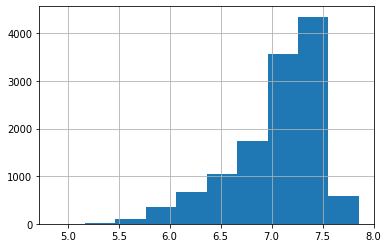

In [41]:
train["anime_id_rate_mean"].hist()